# Testing Ultrasound Contour Detection

This notebook tests the ultrasound contour detection model developed by the global research team

Specifically:
 - I tested (1) A5CH and (2) PLAX LV contour detection models
 - For (1) and (2) I test (A) some provided samples from the research team and (B) randomly selected files from our view recognition dataset. For the view recognition dataset I used 4 different clinics with 4 different files each (Padua, Rigs, Danderyds, and Taiwan).

In [1]:
import os

import matplotlib.pyplot as plt
import torch
from box import Box
import cv2
import numpy as np
import scipy.interpolate as interpolate

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# sys.path.insert(0, "/home/deeplearning/Dev/Ultrasound/ContourDetection/ultrasound_ge/")
sys.path.insert(0, "C:\\Dev\\ContourDetectionGCN\\gcn_ultrasound_segmentation")
from engine import load_trained_model, run_single_epoch
from eval import eval_trained_model
from datasets import load_USKpts

ModuleNotFoundError: No module named 'sacred'

## Helper functions
Simplified from handover code (https://github.build.ge.com/212767663/ultrasound_ge) for Jupyter

In [109]:
def main(config):
    if config['is_gpu']:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device("cpu")

    model, train_params, trained_ds = load_trained_model(weights_filename=config['weights'])

    ds = load_USKpts(img_dirname=config['dirname'],
                     train_filenames_list=None,
                     val_filenames_list=None,
                     test_filenames_list=None,
                     anno_dirname=None,
                     unsupervised_list=None, #unsupervised_list,
                     num_unsupervised=0, #num_unsupervised,
                     input_transformer=None, #trained_ds.input_transformer,
                     input_img_size=224,  #trained_ds.trainset.input_img_size,
                     num_kpts=trained_ds.nb_classes)


    ds.nb_classes = trained_ds.nb_classes
    ds.closed_contour = trained_ds.closed_contour
    
    
    model = model.to(device)
    dataset_name = train_params.dataset
    model_name = train_params.model

    # Get dataloaders
    testloader = torch.utils.data.DataLoader(ds.testset, batch_size=config['batch_size'], shuffle=False,
                                             num_workers=config['num_workers'], pin_memory=True)

    # run test:
    _, _, _, misc = run_single_epoch(mode='test', epoch=1, loader=testloader, optimizer=None, model=model, device=device,
                                     criterion=None, heat_weight=1)
    # Only take the predicted parts of the test output
    fnames, kpts, _, _, _ = misc
    return fnames, kpts, ds

def ultrasound_img_load(img_path):
    img = cv2.imread(img_path)  # .astype(np.uint8)
    ignore_margin = 0
    if img.shape[0] != img.shape[1]:
        # Crop according to us scan region: 708 x 708 size
        ignore_margin = int(0.5 * (max(img.shape[0], img.shape[1]) - min(img.shape[0], img.shape[1]))) #154  # 154*2+708=1016
        img = img[:, ignore_margin: -ignore_margin, :]
    return img, ignore_margin


def plot_image(fname, kpts, ax=None, net_input_img_size=224):
    """ simplified from utils"""
    if ax is None:
        plt.figure()
        ax = plt.gca()
    img, _ = ultrasound_img_load(img_path=fname)
    img = cv2.resize(img, dsize=(net_input_img_size, net_input_img_size), interpolation=cv2.INTER_AREA)
    ax.imshow(img)
    
    interpolation_step_size = 0.001  # 0.01
    unew = np.arange(0, 1.00, interpolation_step_size)
    pred_tck, _ = interpolate.splprep([kpts[:, 0], kpts[:, 1]], s=0)
    pred_interpolate = interpolate.splev(unew, pred_tck)
    ax.scatter(pred_interpolate[0], pred_interpolate[1], marker='.', c='yellow', s=2)
    ax.scatter(kpts[:, 0], kpts[:, 1], marker='.', c='red', s=200)
    clean_ax(ax)
    

def clean_ax(ax):
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    
def plot_all(fnames, kpts, ncols=4, *args, **kwargs):
    nrows = int(np.ceil(len(fnames)/ncols))
    f, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
    for fname, kpt, ax in zip(fnames, kpts, axs.ravel()):
        plot_image(fname, kpt, ax=ax, *args, **kwargs)
    plt.tight_layout()
    
    
    

## Configs
Testing 5CH and PLAX

In [102]:
config = Box(
    batch_size = 8,
    num_workers = 12,
    num_examples_to_plot = 1000,
    is_gpu = True,
)

base_dir = "/home/deeplearning/Data/ContourDetection/"

config_5ch_provided_samples = config.copy()
config_5ch_provided_samples["weights"] = base_dir + "network_weights/weights_5ch_VAEGCN_best_kptsErr.pth"
config_5ch_provided_samples["dirname"] = base_dir + "data_samples/5CH/"

config_5ch_view_rec_samples = config.copy()
config_5ch_view_rec_samples["weights"] = base_dir + "network_weights/weights_5ch_VAEGCN_best_kptsErr.pth"
config_5ch_view_rec_samples["dirname"] = base_dir + "view_rec_test_samples/5CH/"

config_plax_provided_samples = config.copy()
config_plax_provided_samples["weights"] = base_dir + "network_weights/weights_plax_VAEGCN_best_kptsErr.pth"
config_plax_provided_samples["dirname"] = base_dir + "data_samples/PLAX/"

config_plax_view_rec_samples = config.copy()
config_plax_view_rec_samples["weights"] = base_dir + "network_weights/weights_plax_VAEGCN_best_kptsErr.pth"
config_plax_view_rec_samples["dirname"] = base_dir + "view_rec_test_samples/PLAX/"


## Apical 5Chamber - provided samples

In [80]:
fnames, kpts, ds = main(config_5ch_provided_samples)

loading file /home/deeplearning/Data/ContourDetection/network_weights/weights_5ch_VAEGCN_best_kptsErr.pth..
epoch is 1050
Namespace(backbone='resnext101', batch_size=8, colorjitter=2.0, dataset='5ch', epochs=100000, eval_each_epoch=10, feature_vector_size=128, input_img_size=224, learningrate=0.0001, loss=['L2', 'L2'], model='VAEGCN', num_unsupervised=100000, num_workers=8, optimizer='ADAM', overfit=False, print_each_epoch=500, randomcrop=40.0, randomrotate=40.0, seed=1234, subset=200, weights=None)
loading empty dataset.
loading network type: VAEGCN..


Using cache found in /home/deeplearning/.cache/torch/hub/pytorch_vision_v0.6.0
Testing: 01:   0%|          | 0/2 [00:00<?, ?it/s]

current_train_loss = 0.001483
current_val_loss = 0.001714
best_val_metric = 4.810833
Host name: gamma04
Saved to: storage/logs/5ch/VAEGCN/resnext101/5/weights_5ch_VAEGCN_best_kptsErr.pth


Testing: 01: 100%|##########| 2/2 [00:00<00:00,  2.89it/s]


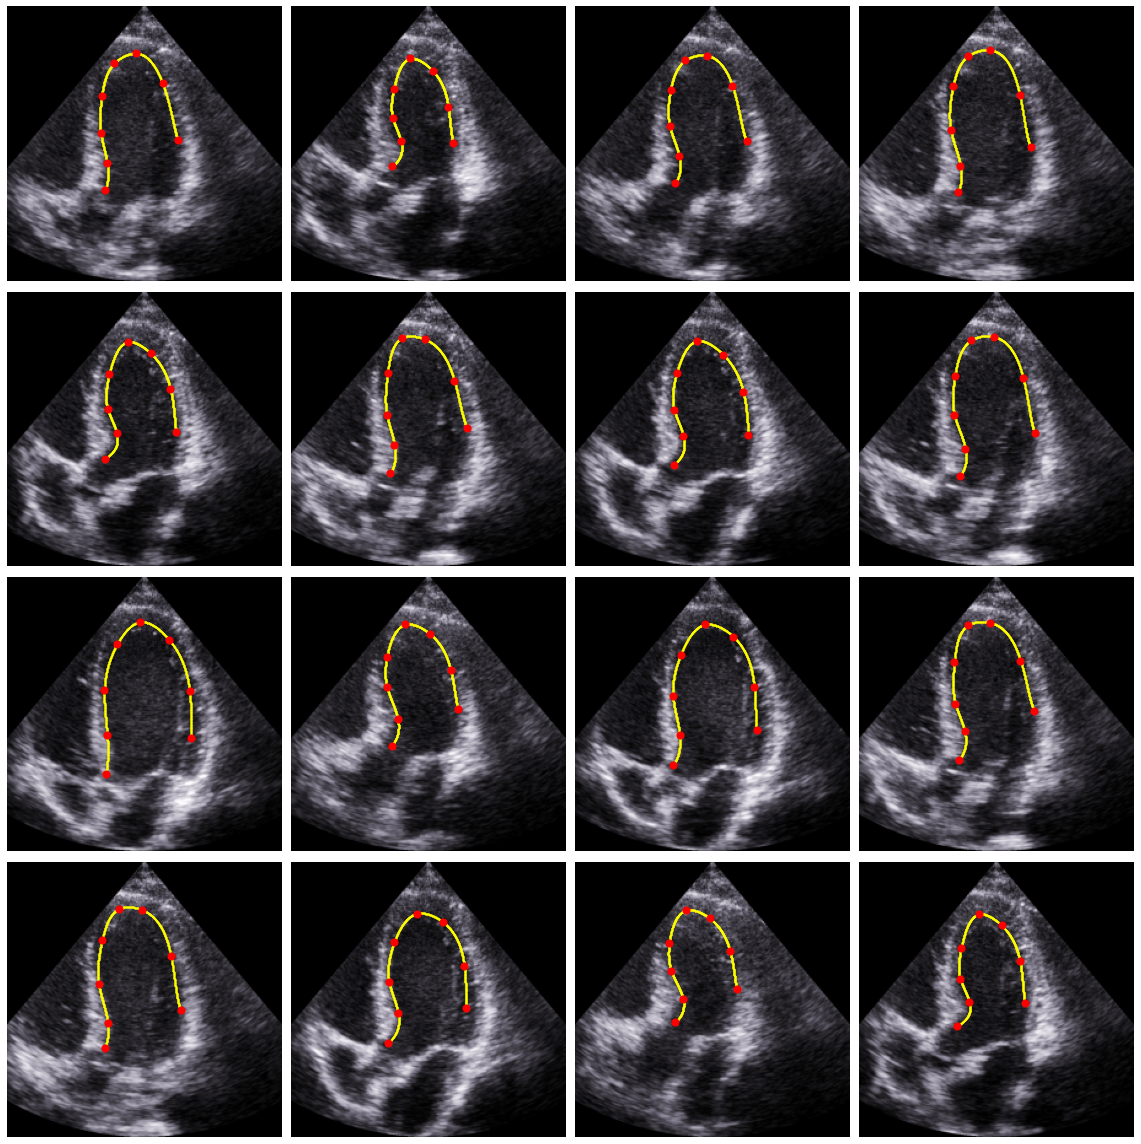

In [88]:
plot_all(fnames, kpts, ncols=4)

## Apical 5Chamber - view recognition samples


In [90]:
fnames, kpts, ds = main(config_5ch_view_rec_samples)

loading file /home/deeplearning/Data/ContourDetection/network_weights/weights_5ch_VAEGCN_best_kptsErr.pth..
epoch is 1050
Namespace(backbone='resnext101', batch_size=8, colorjitter=2.0, dataset='5ch', epochs=100000, eval_each_epoch=10, feature_vector_size=128, input_img_size=224, learningrate=0.0001, loss=['L2', 'L2'], model='VAEGCN', num_unsupervised=100000, num_workers=8, optimizer='ADAM', overfit=False, print_each_epoch=500, randomcrop=40.0, randomrotate=40.0, seed=1234, subset=200, weights=None)
loading empty dataset.
loading network type: VAEGCN..


Using cache found in /home/deeplearning/.cache/torch/hub/pytorch_vision_v0.6.0
Testing: 01:   0%|          | 0/2 [00:00<?, ?it/s]

current_train_loss = 0.001483
current_val_loss = 0.001714
best_val_metric = 4.810833
Host name: gamma04
Saved to: storage/logs/5ch/VAEGCN/resnext101/5/weights_5ch_VAEGCN_best_kptsErr.pth


Testing: 01: 100%|##########| 2/2 [00:00<00:00,  3.13it/s]


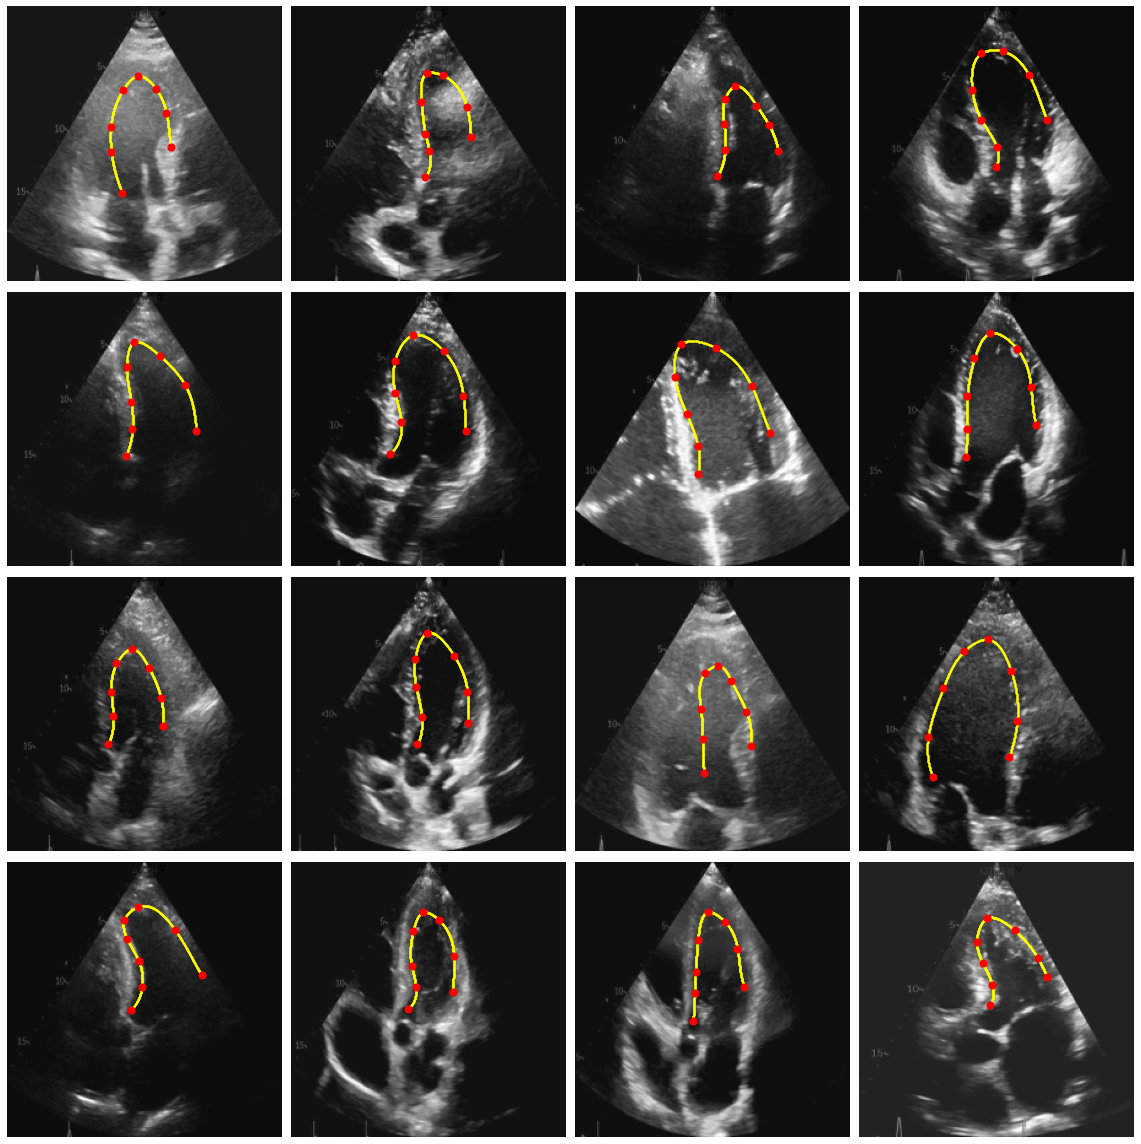

In [91]:
plot_all(fnames, kpts, ncols=4)

## Thoughts on the 5CH model

There are a few cases where the model substantially missed the border, but this was usually in cases with poor image quality.

Overall, I think the model did well here across a range of image qualities and view distributions.

It appears the provided samples are quite consistent in appearance and the model could benefit from some additional images from various clinics. 

## PLAX- provided samples

In [107]:
fnames, kpts, ds = main(config_plax_provided_samples)

loading file /home/deeplearning/Data/ContourDetection/network_weights/weights_plax_VAEGCN_best_kptsErr.pth..
epoch is 3800
Namespace(backbone='resnext101', batch_size=8, colorjitter=2.0, dataset='plax', epochs=100000, eval_interval=10, feature_vector_size=128, input_img_size=224, learningrate=0.0001, loss=['L2', 'L2'], loss_ratio=[1.0, 0.01], model='VAEGCN', num_unsupervised=100000, num_workers=8, optimizer='ADAM', overfit=False, print_each_epoch=500, randomcrop=40.0, randomrotate=40.0, seed=1234, subset_unsupervised=200, weights=None)
loading empty dataset.
loading network type: VAEGCN..


Using cache found in /home/deeplearning/.cache/torch/hub/pytorch_vision_v0.6.0
Testing: 01:   0%|          | 0/4 [00:00<?, ?it/s]

current_train_loss = 0.001686
current_val_loss = 0.003139
best_val_metric = 6.236049
Host name: gamma03
Saved to: storage/logs/plax/VAEGCN/resnext101/28/weights_plax_VAEGCN_best_kptsErr.pth


Testing: 01: 100%|##########| 4/4 [00:00<00:00,  4.66it/s]


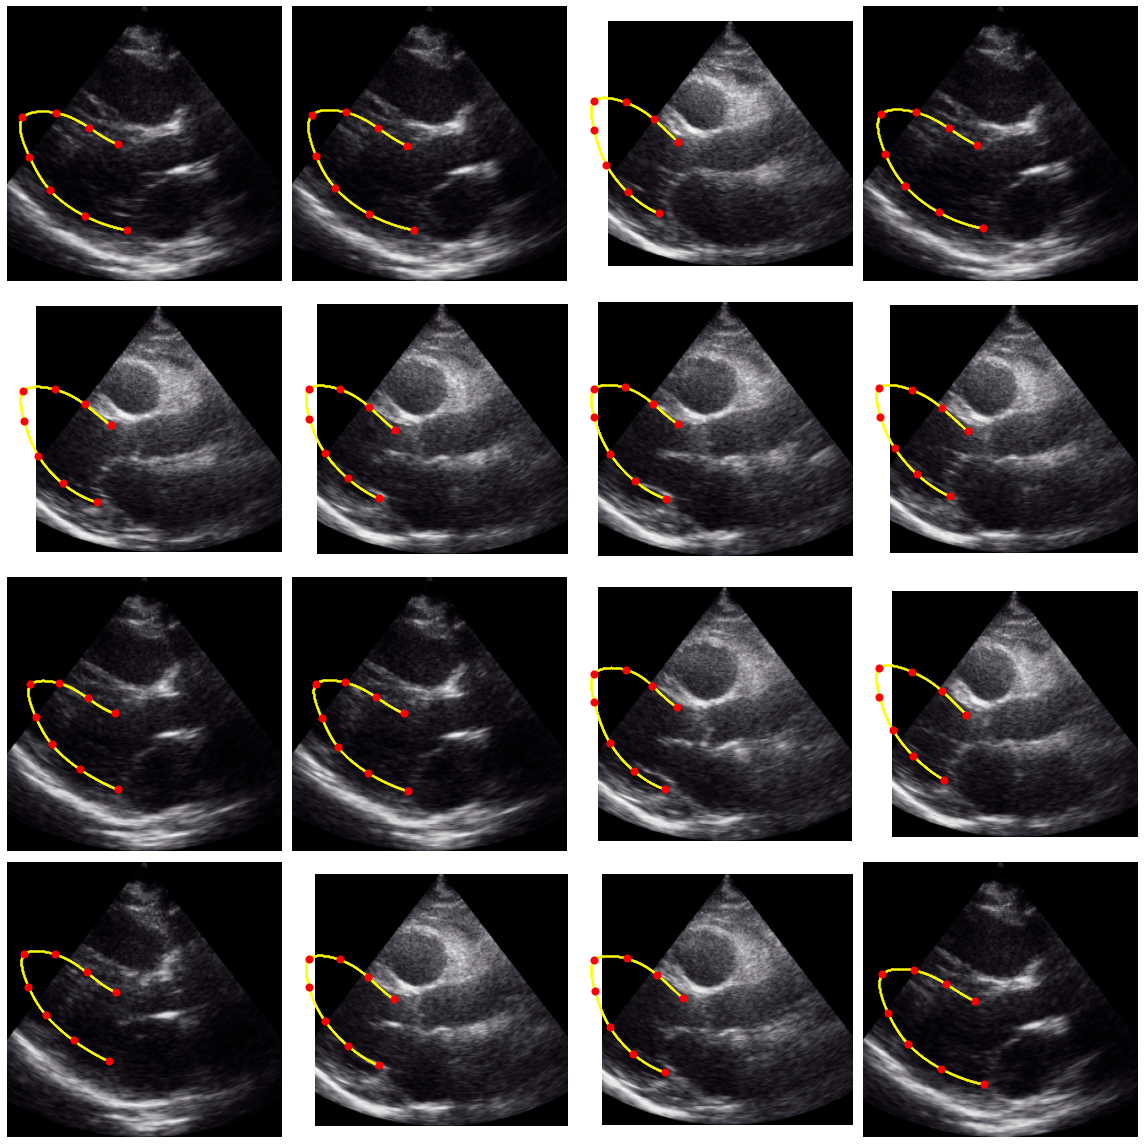

In [108]:
plot_all(fnames[::2], kpts[::2], ncols=4)

## PLAX- view recognition samples

In [104]:
fnames, kpts, ds = main(config_plax_view_rec_samples)

loading file /home/deeplearning/Data/ContourDetection/network_weights/weights_plax_VAEGCN_best_kptsErr.pth..
epoch is 3800
Namespace(backbone='resnext101', batch_size=8, colorjitter=2.0, dataset='plax', epochs=100000, eval_interval=10, feature_vector_size=128, input_img_size=224, learningrate=0.0001, loss=['L2', 'L2'], loss_ratio=[1.0, 0.01], model='VAEGCN', num_unsupervised=100000, num_workers=8, optimizer='ADAM', overfit=False, print_each_epoch=500, randomcrop=40.0, randomrotate=40.0, seed=1234, subset_unsupervised=200, weights=None)
loading empty dataset.
loading network type: VAEGCN..


Using cache found in /home/deeplearning/.cache/torch/hub/pytorch_vision_v0.6.0
Testing: 01:   0%|          | 0/2 [00:00<?, ?it/s]

current_train_loss = 0.001686
current_val_loss = 0.003139
best_val_metric = 6.236049
Host name: gamma03
Saved to: storage/logs/plax/VAEGCN/resnext101/28/weights_plax_VAEGCN_best_kptsErr.pth


Testing: 01: 100%|##########| 2/2 [00:00<00:00,  3.22it/s]


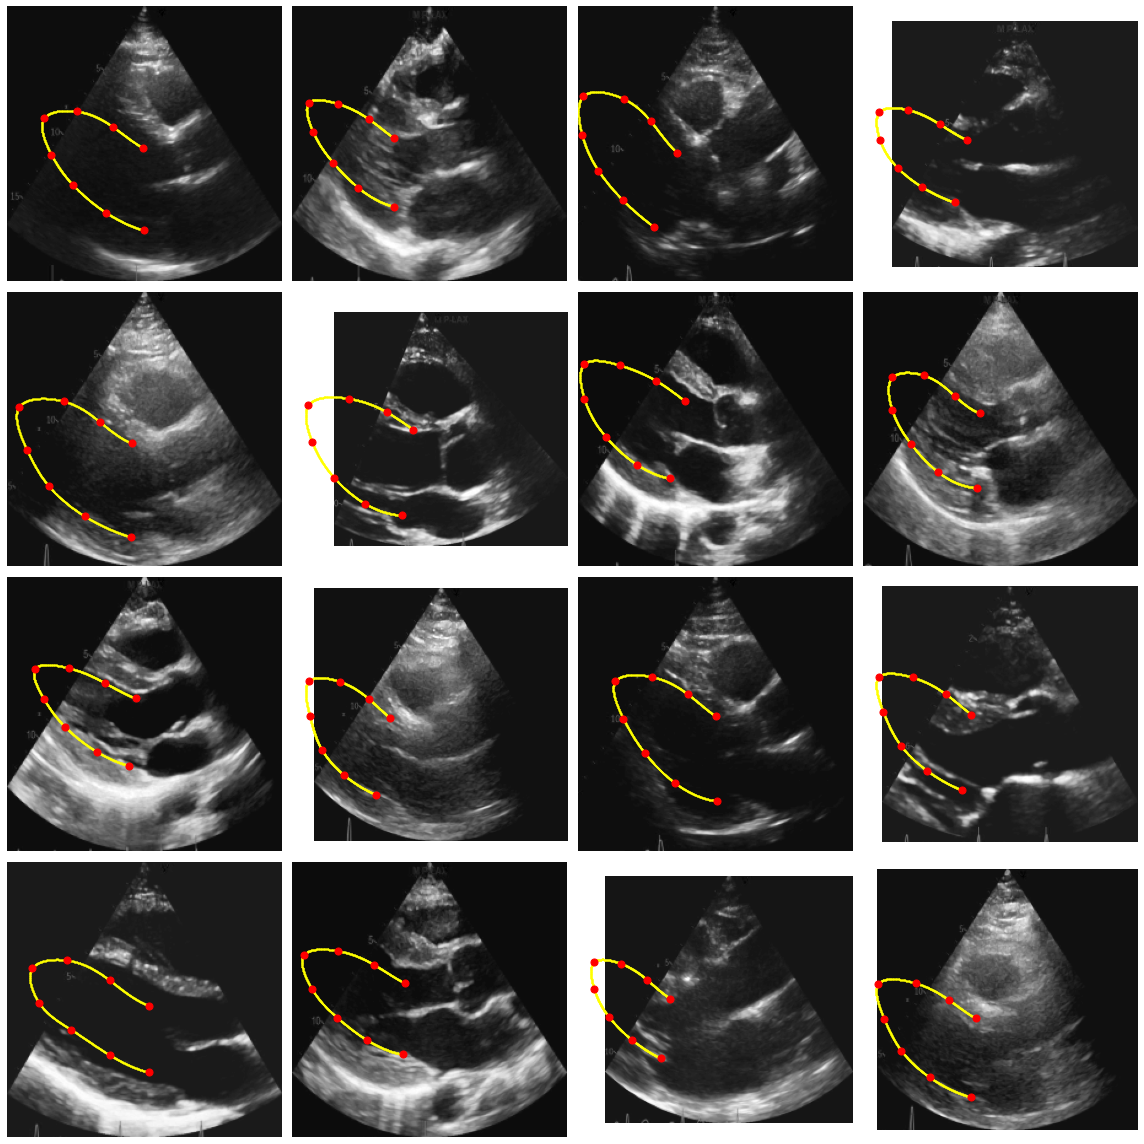

In [105]:
plot_all(fnames, kpts, ncols=4)

## Thoughts on the PLAX model

I think the model is quite often finding the papillary muscles rather than the posterior wall. However, I think this is probably a function of the training data since the provided samples show the same charactersitic.

The septum is quite a bit lower than desired in a few of our samples

Also, the location of the points in the long axis of the heart seems to vary substantially between images in our samples.

Overall, mixed review here, but perhaps just need more data with more consistent labeling. Some results are likely because we have a different distribution of appearance and zooming parameters than was seen in training.


In [112]:
import torch.onnx

In [121]:
dummy_input = torch.zeros((1, 3, 224, 224)).cuda()
model, _, _ = load_trained_model(weights_filename=config_5ch_provided_samples['weights'])
model = model.cuda()

loading file /home/deeplearning/Data/ContourDetection/network_weights/weights_5ch_VAEGCN_best_kptsErr.pth..
epoch is 1050
Namespace(backbone='resnext101', batch_size=8, colorjitter=2.0, dataset='5ch', epochs=100000, eval_each_epoch=10, feature_vector_size=128, input_img_size=224, learningrate=0.0001, loss=['L2', 'L2'], model='VAEGCN', num_unsupervised=100000, num_workers=8, optimizer='ADAM', overfit=False, print_each_epoch=500, randomcrop=40.0, randomrotate=40.0, seed=1234, subset=200, weights=None)
loading empty dataset.
loading network type: VAEGCN..


Using cache found in /home/deeplearning/.cache/torch/hub/pytorch_vision_v0.6.0


current_train_loss = 0.001483
current_val_loss = 0.001714
best_val_metric = 4.810833
Host name: gamma04
Saved to: storage/logs/5ch/VAEGCN/resnext101/5/weights_5ch_VAEGCN_best_kptsErr.pth


In [122]:
torch.onnx.export(model,               # model being run
                  dummy_input,                         # model input (or a tuple for multiple inputs)
                  "./super_resolution.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

## Load some other models for performance testing

In [2]:
from models import load_model
from CVUSInference.Utilities.model_profiler import profile_model

ModuleNotFoundError: No module named 'GPUtil'

In [5]:
resnet18 = load_model("VAEGCN", nb_classes=12, feature_vector_size=128, backbone=18, is_gpu=True, inference_model=True)
resnet18 = resnet18.cuda()
mobilenet = load_model("VAEGCN", nb_classes=12, feature_vector_size=128, backbone="mobilenet", is_gpu=True, inference_model=True)
mobilenet = mobilenet.cuda()

loading network type: VAEGCN..


Using cache found in C:\Users\212686118/.cache\torch\hub\pytorch_vision_v0.6.0


using inference model so image_decoder will not be included in forward pass
loading network type: VAEGCN..


Using cache found in C:\Users\212686118/.cache\torch\hub\pytorch_vision_v0.6.0
Downloading: "http://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\212686118/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

using inference model so image_decoder will not be included in forward pass


In [6]:
dummy_input = torch.zeros((1, 3, 224, 224)).cuda()

In [11]:
print(profile_model(resnet18, (32, 3, 224, 224)))
print(profile_model(mobilenet, (32, 3, 224, 224)))

{'inf_time': 69.79852447509765, 'mem_usage': 218.0, 'params': 13817701}
{'inf_time': 76.72786331176758, 'mem_usage': 470.0, 'params': 5700645}


In [9]:
torch.onnx.export(resnet18,               # model being run
                  dummy_input,                         # model input (or a tuple for multiple inputs)
                  "./resnet18_opset11.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                 )

In [10]:
torch.onnx.export(mobilenet,               # model being run
                  dummy_input,                         # model input (or a tuple for multiple inputs)
                  "./mobilenet_opset11.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                 )

In [12]:
resnet18(dummy_input)

tensor([[[0.7305, 1.6020],
         [0.7463, 1.5711],
         [0.7136, 1.6471],
         [0.6621, 1.6117],
         [0.6778, 1.5928],
         [0.7426, 1.6158],
         [0.7419, 1.6980],
         [0.7661, 1.7547]]], device='cuda:0', grad_fn=<AddBackward0>)